# Hubway project - python
To better familiarize myself with Lasso in python, I reimplemented the core features.
### Import libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LassoCV
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Load trip data, and parse the date

In [2]:
trips_df = pd.read_csv('hubway_trips.csv', parse_dates=['start_date'])
trips_df.set_index('seq_id', inplace=True)
trips_df.head(2)

,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
seq_id,,,,,,,,,,,,
1,8,Closed,9,2011-07-28 10:12:00,23,7/28/2011 10:12:00,23,B00468,Registered,'97217,1976,Male
2,9,Closed,220,2011-07-28 10:21:00,23,7/28/2011 10:25:00,23,B00554,Registered,'02215,1966,Male


In [3]:
parsed_dates = pd.to_datetime(trips_df['start_date'], format = '%m/%d/%Y %H:%M:%S')
parsed_dates = parsed_dates.apply(lambda x: x.replace(minute=0))

In [4]:
trips_df.start_date = parsed_dates
trips_df.head(2)

,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
seq_id,,,,,,,,,,,,
1,8,Closed,9,2011-07-28 10:00:00,23,7/28/2011 10:12:00,23,B00468,Registered,'97217,1976,Male
2,9,Closed,220,2011-07-28 10:00:00,23,7/28/2011 10:25:00,23,B00554,Registered,'02215,1966,Male


In [5]:
group_trips_df= trips_df.groupby('start_date')['status'].count()
group_trips_df.index.name = 'date_time'
group_trips_df.name = 'trip_counts'
group_trips_df.head(3)

date_time
2011-07-28 10:00:00     8
2011-07-28 11:00:00     4
2011-07-28 12:00:00    66
Name: trip_counts, dtype: int64

### Load the weather data, and merge the dataframes

In [6]:
weather_df = pd.read_csv('boston_weather.csv', parse_dates=[['date', 'time']])
weather_df['date_time'] = weather_df['date_time'].apply(lambda x: x.replace(minute=0))
weather_df.set_index('date_time', inplace=True)
weather_df.head(2)

,Unnamed: 0,temp,dew_pt,humidity,pressure,visibility,wind_dir,wind_speed,gust_speed,precipitation,events,conditions,wind_dir_deg
date_time,,,,,,,,,,,,,
2011-07-28 00:00:00,1,73,59,61,29.98,10,North,5.8,0,0,NaN,Partly Cloudy,350
2011-07-28 01:00:00,2,68,64,87,30.02,-9999,North,5.8,0,0,NaN,Clear,350


In [7]:
# clean weather data
#weather_df['temp'][weather_df['temp'] < -100] = weather_df['temp'].mean()
weather_df.visibility[weather_df.visibility <0] = weather_df.visibility.mean()
weather_df =weather_df[weather_df['pressure'] >=0 ]
weather_df =weather_df[weather_df['temp'] >=-100 ]
weather_df =weather_df[weather_df['wind_speed'] >=-100 ]
weather_df =weather_df[weather_df['dew_pt'] >=-100 ]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
weather_df.describe()

,Unnamed: 0,temp,dew_pt,humidity,pressure,visibility,wind_speed,gust_speed,precipitation,wind_dir_deg
count,24666.000000,24666.000000,24666.000000,24666.000000,24666.000000,24666.000000,24666.000000,24666.000000,24666.000000,24666.000000
mean,12353.794170,54.454322,43.527479,69.484148,29.983016,8.489931,10.343193,5.018994,0.007974,193.501176
std,7126.366684,16.147978,17.987634,19.706649,0.249934,2.955285,5.653073,10.764721,0.041949,106.914191
min,1.000000,3.900000,-15.000000,10.000000,28.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6185.250000,41.000000,30.000000,54.000000,29.820000,9.000000,6.900000,0.000000,0.000000,100.000000
50%,12352.500000,55.400000,46.000000,71.000000,29.990000,10.000000,9.200000,0.000000,0.000000,210.000000
75%,18520.750000,66.900000,57.900000,87.000000,30.150000,10.000000,13.800000,0.000000,0.000000,290.000000
max,24736.000000,99.000000,75.900000,100.000000,30.800000,10.000000,44.900000,97.800000,1.320000,360.000000


In [9]:
merged_df = weather_df.join(pd.DataFrame(group_trips_df),how='inner')
merged_df.drop(merged_df.columns[0], axis = 1, inplace=True)
merged_df.head(3)

,temp,dew_pt,humidity,pressure,visibility,wind_dir,wind_speed,gust_speed,precipitation,events,conditions,wind_dir_deg,trip_counts
date_time,,,,,,,,,,,,,
2011-07-28 10:00:00,73.0,61,66,30.07,10,East,9.2,0,0,NaN,Scattered Clouds,100,8
2011-07-28 11:00:00,73.0,63,71,30.07,10,ESE,8.1,0,0,NaN,Scattered Clouds,120,4
2011-07-28 12:00:00,73.9,63,68,30.06,10,ESE,9.2,0,0,NaN,Scattered Clouds,120,66


In [10]:
merged_df['day_week'] = merged_df.index.weekday
merged_df.day_week = merged_df.day_week.astype('category')
merged_df['hour'] = merged_df.index.hour
merged_df.hour = merged_df.hour.astype('category')
merged_df['sqrt_trips'] = np.sqrt(merged_df['trip_counts'])
merged_dummy_df = pd.get_dummies(merged_df)

In [11]:
# interaction is not as clean as R, at least in scikitlearn
interact_func = PolynomialFeatures(interaction_only=True)
#pd.concat([merged_df, pd.DataFrame(poly.fit_transform(merged_df[['hour', 'day_week']]) )], axis = 1 )#

### Explore features

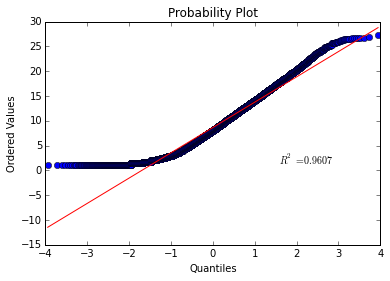

In [12]:
import scipy.stats as stats
import pylab
stats.probplot(merged_df['sqrt_trips'], dist='norm', plot=pylab);

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


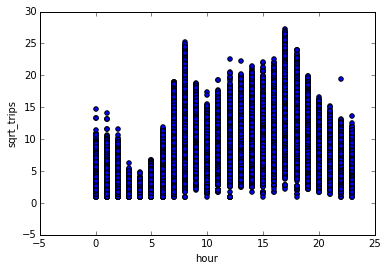

In [13]:
merged_df.plot('hour', 'sqrt_trips', kind='scatter');

### Set up the regression and run it

In [15]:
feature_col = merged_dummy_df.columns[:9].union( merged_dummy_df.columns[11:-1])
merged_dummy_df.columns[9:11]

Index(['trip_counts', 'sqrt_trips'], dtype='object')

In [16]:
hubway_lasso = LassoCV(cv = 10, max_iter = 100, normalize=True, n_jobs = -1) # the normalization is important!

In [17]:
hubway_lasso.fit(merged_dummy_df[feature_col], merged_dummy_df['sqrt_trips'])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

Which features are important?

In [35]:
feature_col[np.isclose(abs(hubway_lasso.coef_), 0)]

Index(['conditions_Heavy Drizzle', 'conditions_Light Rain',
       'conditions_Light Snow', 'conditions_Light Thunderstorms and Rain',
       'conditions_Mist', 'conditions_Overcast', 'conditions_Partly Cloudy',
       'conditions_Patches of Fog', 'day_week_1', 'dew_pt',
       'events_Fog-Rain-Thunderstorm', 'events_Snow', 'gust_speed', 'hour_22',
       'wind_dir_Calm', 'wind_dir_NNE', 'wind_dir_NNW', 'wind_dir_NW',
       'wind_dir_North', 'wind_dir_SSW', 'wind_dir_Variable', 'wind_dir_WNW',
       'wind_speed'],
      dtype='object')

In [36]:
feature_col[hubway_lasso.coef_ > 0]

Index(['conditions_Fog', 'conditions_Haze', 'conditions_Mostly Cloudy',
       'conditions_Scattered Clouds', 'day_week_2', 'day_week_3', 'day_week_4',
       'events_Fog', 'events_Thunderstorm', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_7', 'hour_8', 'hour_9',
       'pressure', 'temp', 'visibility', 'wind_dir_ENE', 'wind_dir_ESE',
       'wind_dir_East', 'wind_dir_SE', 'wind_dir_West'],
      dtype='object')

In [21]:
'+'.join(feature_col[np.isclose(abs(hubway_lasso.coef_), 0)])

'conditions_Heavy Drizzle+conditions_Light Rain+conditions_Light Snow+conditions_Light Thunderstorms and Rain+conditions_Mist+conditions_Overcast+conditions_Partly Cloudy+conditions_Patches of Fog+day_week_1+dew_pt+events_Fog-Rain-Thunderstorm+events_Snow+gust_speed+hour_22+wind_dir_Calm+wind_dir_NNE+wind_dir_NNW+wind_dir_NW+wind_dir_North+wind_dir_SSW+wind_dir_Variable+wind_dir_WNW+wind_speed'

How good was the fit? First the R<sup>2</sup>

In [22]:
hubway_lasso.score(merged_dummy_df[feature_col], merged_dummy_df['sqrt_trips'])

0.61032794984980399

In [44]:
np.sqrt(hubway_lasso.mse_path_.mean(axis=1).min())

3.5441249932957031

### statsmodels

In [31]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
normalized_merged_df = scaler.fit_transform(merged_dummy_df[feature_col])

In [32]:
import patsy
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols
statsmodels_lasso = OLS(merged_dummy_df['trip_counts'],normalized_merged_df)
merged_df.hour = merged_df.hour.astype('object')
merged_df.day_week = merged_df.day_week.astype('object')
formula_lasso = ols('sqrt_trips ~ conditions + temp + day_week* hour', merged_df)

In [37]:
results = formula_lasso.fit_regularized(maxiter=100)

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_trips   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     195.1
Date:                Sat, 14 Nov 2015   Prob (F-statistic):               0.00
Time:                        13:16:04   Log-Likelihood:                -43724.
No. Observations:               17508   AIC:                         8.783e+04
Df Residuals:                   17318   BIC:                         8.930e+04
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.8432      0.313      2.694      0.007         0.230     1.457
conditions[T.Drizzle]                          -5.3303      2.101     -2.537      0.011        -9.449    -1.212
conditions[T.Fog]                               0.7646      0.234      3.268      0.001         0.306     1.223
conditions[T.Haze]                             -0.5207      0.557     -0.935      0.350        -1.613     0.571
conditions[T.Heavy Drizzle]                     1.3549      2.972      0.456      0.648        -4.470     7.180
conditions[T.Heavy Rain]                       -4.7214      0.225    -20.972      0.000        -5.163    -4.280
conditions[T.Heavy Thunderstorms and Rain]     -4.2303      0.461     -9.171      0.000        -5.135    -3.326
conditions[T.Heavy Thunderstorms with Hail]    -7.0022      2.971     -2.357      0.018       -12.826    -1.178
conditions[T.Light Drizzle]                    -1.9153      0.250     -7.676      0.000        -2.404    -1.426
conditions[T.Light Rain]                       -3.0720      0.104    -29.654      0.000        -3.275    -2.869
conditions[T.Light Snow]                       -1.9741      0.438     -4.502      0.000        -2.834    -1.115
conditions[T.Light Thunderstorms and Rain]     -2.3713      0.416     -5.702      0.000        -3.186    -1.556
conditions[T.Mist]                              0.1862      0.946      0.197      0.844        -1.667     2.040
conditions[T.Mostly Cloudy]                     0.3556      0.087      4.082      0.000         0.185     0.526
conditions[T.Overcast]                         -0.3616      0.084     -4.318      0.000        -0.526    -0.197
conditions[T.Partly Cloudy]                     0.3013      0.093      3.229      0.001         0.118     0.484
conditions[T.Patches of Fog]                   -0.4102      2.972     -0.138      0.890        -6.236     5.416
conditions[T.Rain]                             -5.1699      0.173    -29.903      0.000        -5.509    -4.831
conditions[T.Scattered Clouds]                  0.4043      0.091      4.468      0.000         0.227     0.582
conditions[T.Thunderstorm]                     -2.0172      0.799     -2.524      0.012        -3.584    -0.450
conditions[T.Thunderstorms and Rain]           -5.2645      0.705     -7.465      0.000        -6.647    -3.882
conditions[T.Unknown]                          -3.1117      2.101     -1.481      0.139        -7.230     1.006
day_week[T.1]                                  -0.8671      0.420     -2.064      0.039        -1.691    -0.043
day_week[T.2]                                  -0.5855      0.409     -1.430      0.153        -1.388     0.217
day_week[T.3]                                   0.0346     

In [43]:
np.sqrt(results.mse_resid)

2.9561718478039167

In [ ]:
simple_ols = ols('sqrt_trips ~ conditions + wind_speed + humidity + temp ', merged_df)
simple = simple_ols.fit(maxiter=100)
simple.summary()

In [ ]:
merged_df.drop('events', axis=1, inplace=True)
merged_df.head()

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 6)
pca_df = pca.fit_transform(merged_df[['temp', 'dew_pt', 'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation']])

In [ ]:
pca_df.shape

In [ ]:
temp = pd.DataFrame(pca_df, index=merged_df.index)
import re
hour_col = [ col for col in merged_dummy_df if re.search('^hour', col) ]
pca_df2 = pd.concat([temp,  merged_dummy_df['sqrt_trips'], merged_dummy_df[hour_col]], axis=1)

In [ ]:
pca_df2.head(3)

In [ ]:
pca_col = pca_df2.columns[:6].union(pca_df2.columns[7:])
#pca_df2['hour'] = pca_df2['hour'].astype(int)
pca_lasso = OLS(pca_df2['sqrt_trips'].values, pca_df2[pca_col])

In [ ]:
pca_result = pca_lasso.fit_regularized(maxiter=100)

In [ ]:
pca_result.summary()